In [ ]:
# Notebook 01: EXPLORATORY DATA ANALYSIS (EDA)

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [ ]:
# 1. ЗАГРУЗКА ДАННЫХ

In [2]:
df = pd.read_excel('../data/Dataset-region-52.xlsx')

selected_vars = [
    'potras',    # Y
    'doxodsn',   # X1
    'natdox',    # X2
    'nalog',     # X3
    'ssber',     # X4
    'denras',    # X5
    'fakt',      # X6
    'kvzv',      # X7
    'dhpens'     # X8
]

df_analysis = df[selected_vars].copy()

print(f"Размер выборки: {df_analysis.shape[0]} наблюдений")
print(f"Количество переменных: {df_analysis.shape[1]} (1 зависимая + 8 объясняющих)")

Размер выборки: 2605 наблюдений
Количество переменных: 9 (1 зависимая + 8 объясняющих)


In [ ]:
# 2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА

In [3]:
desc_stats = df_analysis.describe().T
desc_stats['cv%'] = (desc_stats['std'] / desc_stats['mean'] * 100).round(2)
desc_stats['skewness'] = df_analysis.skew().round(3)
desc_stats['kurtosis'] = df_analysis.kurtosis().round(3)

print("\n", desc_stats[['mean', 'std', 'min', 'max', 'cv%', 'skewness', 'kurtosis']])

# Сохранение
desc_stats.to_csv('../results/tables/descriptive_statistics.csv')
print("\nОписательная статистика сохранена")


                   mean            std           min           max      cv%  \
potras   103622.118380   87441.545706  1.668411e+04  2.853783e+06    84.39   
doxodsn  128985.390411   82008.213292  2.466843e+04  1.154605e+06    63.58   
natdox     8898.572468   11449.289450  0.000000e+00  1.045838e+05   128.66   
nalog      8886.834871   11593.630381  0.000000e+00  1.474067e+05   130.46   
ssber     11102.018852   22630.711510  0.000000e+00  5.055000e+05   203.84   
denras   122982.342000  109955.315113  2.124475e+04  2.994837e+06    89.41   
fakt       6003.048411   70814.625750 -2.337620e+06  2.900000e+05  1179.64   
kvzv       1107.727814    2276.383186  2.005486e+01  3.211592e+04   205.50   
dhpens        0.357390       0.479323  0.000000e+00  1.000000e+00   134.12   

         skewness  kurtosis  
potras     14.418   394.238  
doxodsn     3.407    24.044  
natdox      2.644    11.137  
nalog       2.442    13.043  
ssber       8.133   120.803  
denras     12.209   261.116  
fakt   

In [ ]:
# 3. ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ЗАВИСИМОЙ ПЕРЕМЕННОЙ

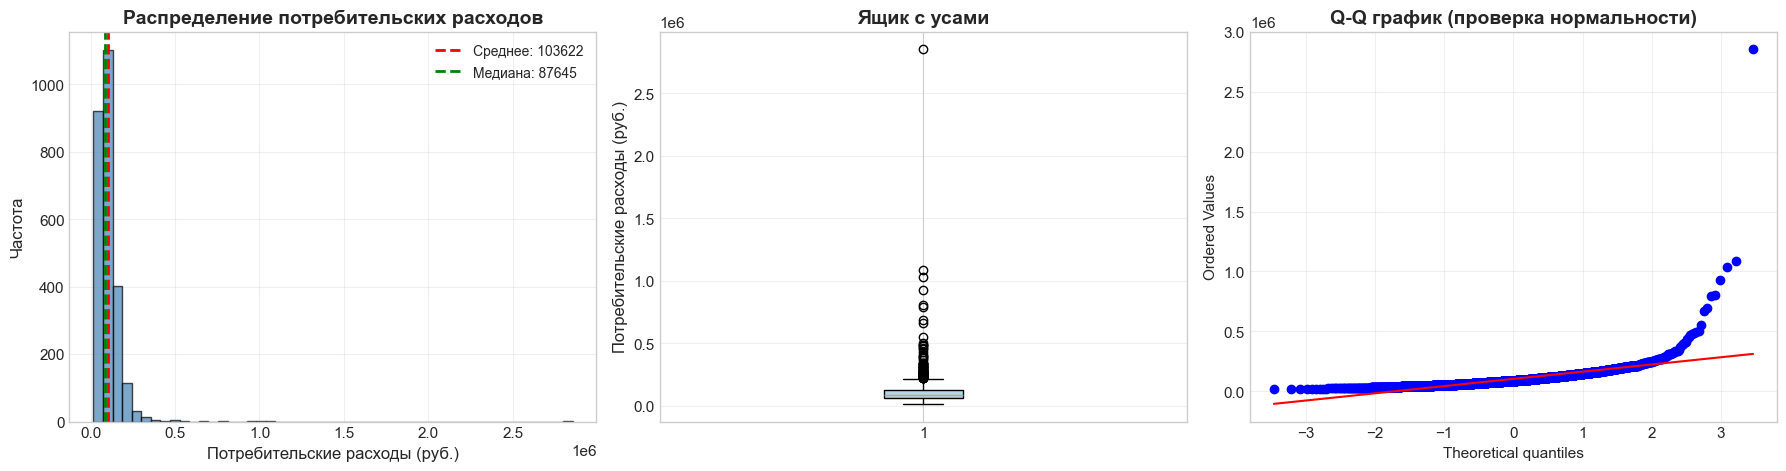


График распределения Y сохранен


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Гистограмма
axes[0].hist(df_analysis['potras'], bins=50, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(df_analysis['potras'].mean(), color='red', 
                linestyle='--', linewidth=2, 
                label=f'Среднее: {df_analysis["potras"].mean():.0f}')
axes[0].axvline(df_analysis['potras'].median(), color='green', 
                linestyle='--', linewidth=2,
                label=f'Медиана: {df_analysis["potras"].median():.0f}')
axes[0].set_xlabel('Потребительские расходы (руб.)', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Распределение потребительских расходов', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Boxplot
bp = axes[1].boxplot(df_analysis['potras'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[1].set_ylabel('Потребительские расходы (руб.)', fontsize=12)
axes[1].set_title('Ящик с усами', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Q-Q plot
stats.probplot(df_analysis['potras'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q график (проверка нормальности)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/y_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nГрафик распределения Y сохранен")

In [ ]:
# 4. ВИЗУАЛИЗАЦИЯ: ЗАВИСИМОСТЬ Y ОТ КАЖДОГО X

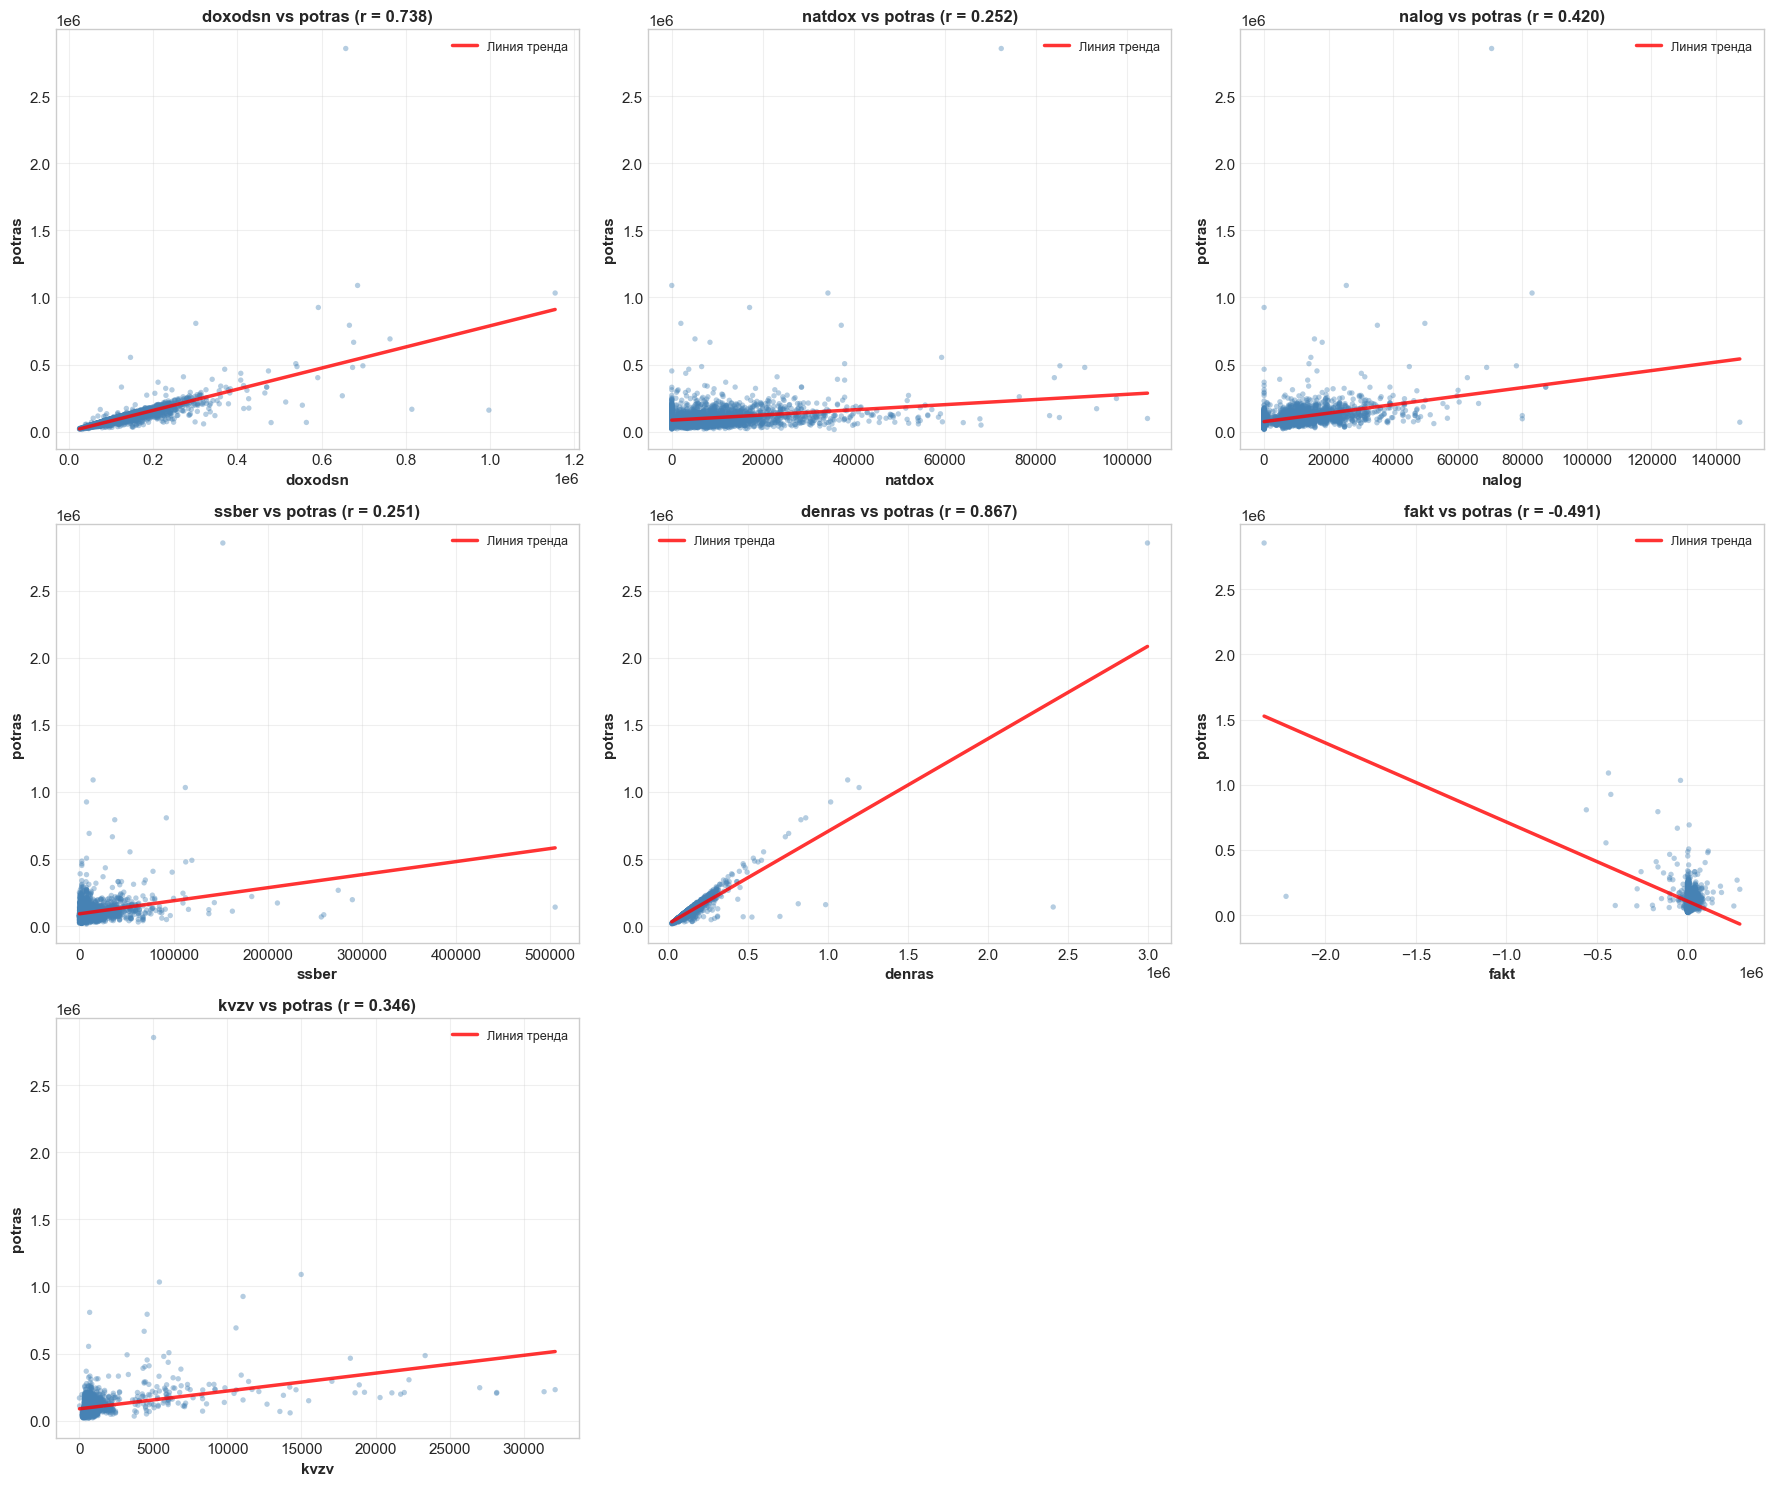

Scatter plots сохранены


In [5]:
continuous_vars = ['doxodsn', 'natdox', 'nalog', 'ssber', 
                   'denras', 'fakt', 'kvzv']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, var in enumerate(continuous_vars):
    # Scatter plot
    axes[i].scatter(df_analysis[var], df_analysis['potras'], 
                   alpha=0.4, s=15, color='steelblue', edgecolor='none')
    
    # Линия тренда
    z = np.polyfit(df_analysis[var], df_analysis['potras'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_analysis[var].min(), df_analysis[var].max(), 100)
    axes[i].plot(x_trend, p(x_trend), color='red', linewidth=2.5, 
                label='Линия тренда', alpha=0.8)
    
    # Корреляция
    corr = df_analysis[[var, 'potras']].corr().iloc[0, 1]
    
    axes[i].set_xlabel(var, fontsize=11, fontweight='bold')
    axes[i].set_ylabel('potras', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{var} vs potras (r = {corr:.3f})', 
                     fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

# Удалить лишние оси
for j in range(len(continuous_vars), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../results/figures/scatter_plots_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scatter plots сохранены")

In [18]:
# 5. BOXPLOT ДЛЯ БИНАРНОЙ ПЕРЕМЕННОЙ

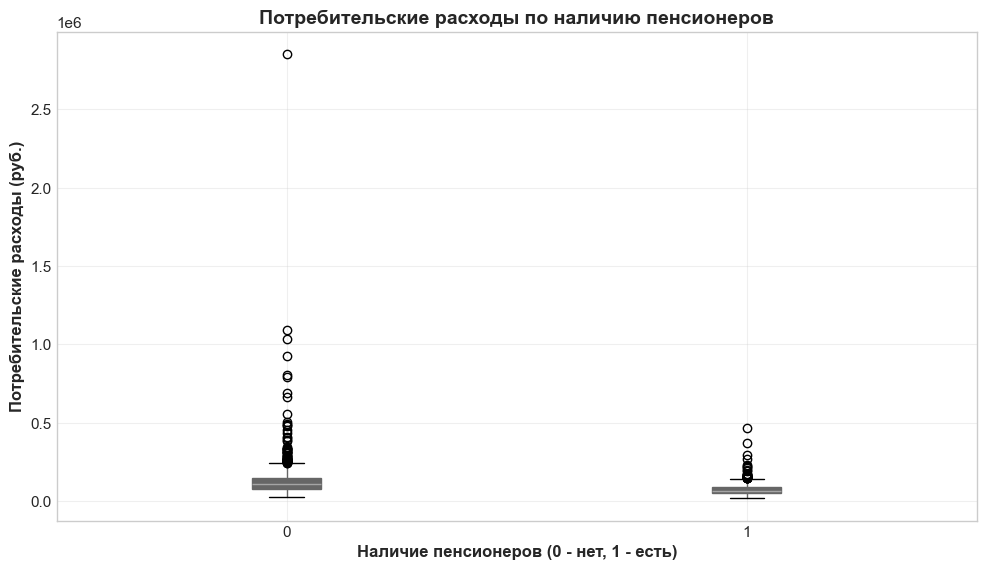

Boxplot для бинарной переменной сохранен


In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

df_analysis.boxplot(column='potras', by='dhpens', ax=ax, patch_artist=True)
ax.set_xlabel('Наличие пенсионеров (0 - нет, 1 - есть)', fontsize=12, fontweight='bold')
ax.set_ylabel('Потребительские расходы (руб.)', fontsize=12, fontweight='bold')
ax.set_title('Потребительские расходы по наличию пенсионеров', 
            fontsize=14, fontweight='bold')
ax.get_figure().suptitle('')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/boxplot_dhpens.png', dpi=300, bbox_inches='tight')
plt.show()

print("Boxplot для бинарной переменной сохранен")

In [ ]:
# 6. ПРЕДПОЛОЖЕНИЯ О ВЛИЯНИИ ПЕРЕМЕННЫХ

doxodsn: (+) Положительное: рост дохода увеличивает потребление
natdox: (+) Положительное: дополнительные ресурсы увеличивают возможности
nalog: (-) Отрицательное: налоги снижают располагаемый доход
ssber: (-) Отрицательное: сбережения конкурируют с потреблением
denras: (+) Положительное: общие расходы включают потребительские
fakt: (?) Неопределенное: зависит от источника дефицита/профицита
kvzv: (?) Неопределенное: технический коэффициент коррекции
dhpens: (-) Отрицательное: пенсионеры имеют меньшие доходы и расходы

In [ ]:
# 7. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ


Корреляция объясняющих переменных с potras:
potras     1.000000
denras     0.866978
doxodsn    0.738021
nalog      0.419803
kvzv       0.345776
natdox     0.251684
ssber      0.251402
dhpens    -0.269728
fakt      -0.491495
Name: potras, dtype: float64


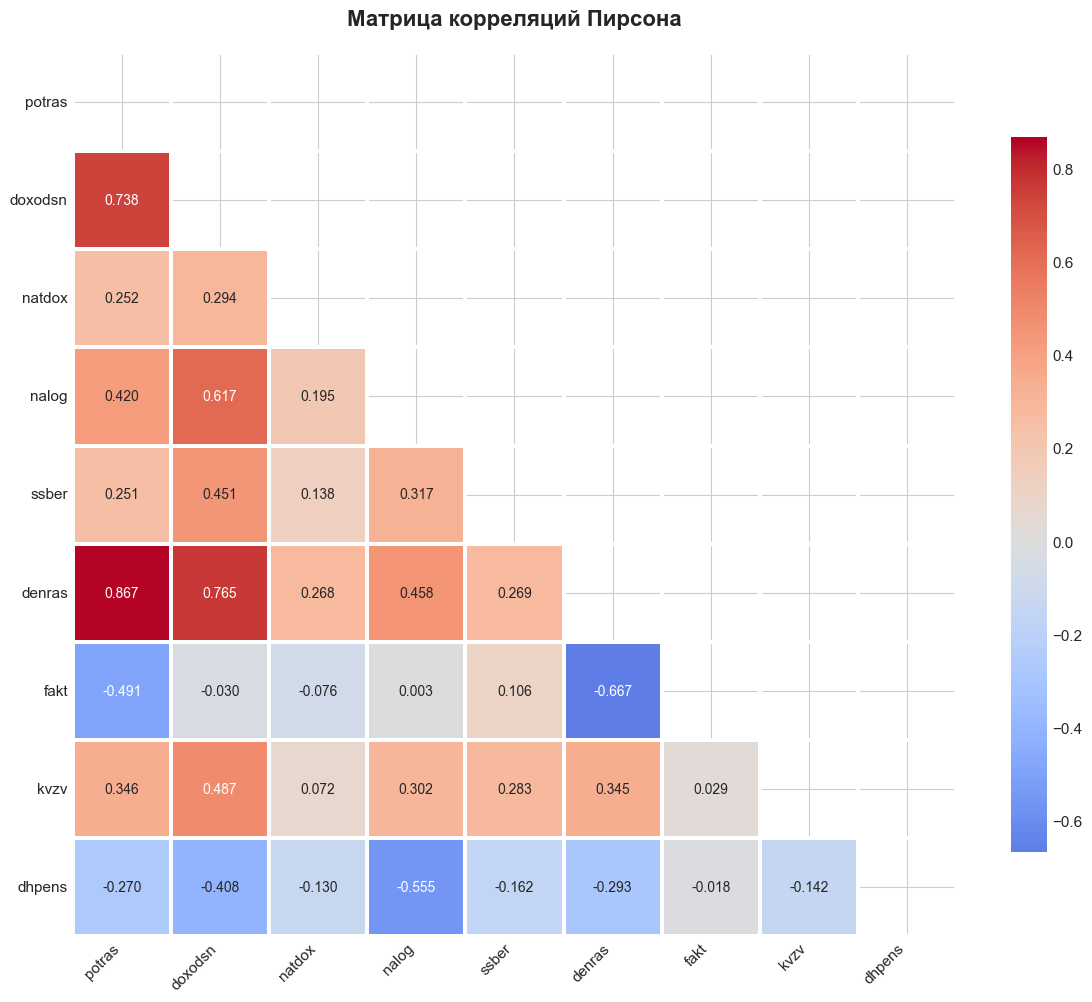


Матрица корреляций сохранена


In [7]:
# Матрица корреляций
corr_matrix = df_analysis.corr()

print("\nКорреляция объясняющих переменных с potras:")
print(corr_matrix['potras'].sort_values(ascending=False))

# Тепловая карта
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, square=True, 
            linewidths=1.5, cbar_kws={"shrink": 0.8},
            annot_kws={"fontsize": 10})
plt.title('Матрица корреляций Пирсона', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.savefig('../results/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохранение
corr_matrix.to_csv('../results/tables/correlation_matrix.csv')
print("\nМатрица корреляций сохранена")

In [ ]:
# 8. ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ: VIF


 Переменная      VIF
   doxodsn      inf
    denras      inf
      fakt      inf
     nalog 1.620838
      kvzv 1.331222
     ssber 1.290043
    natdox 1.108440

Интерпретация:
  VIF < 5      : Мультиколлинеарность отсутствует
  5 ≤ VIF < 10 : Умеренная мультиколлинеарность
  VIF ≥ 10     : Сильная мультиколлинеарность

ПЕРЕМЕННЫЕ С ВЫСОКИМ VIF (≥10):
Переменная  VIF
   doxodsn  inf
    denras  inf
      fakt  inf


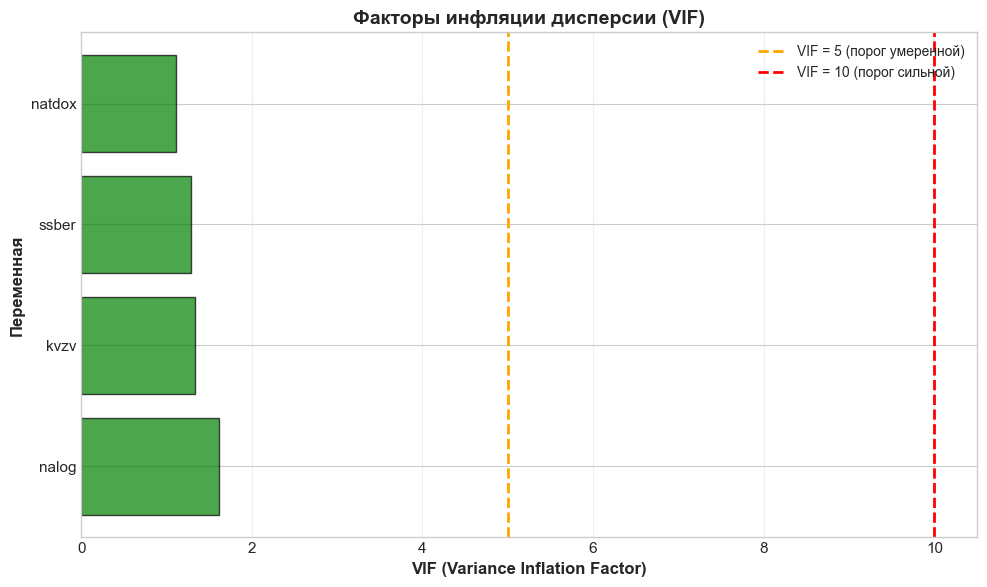


Результаты VIF сохранены


In [10]:
# Только непрерывные переменные для VIF
X_continuous = df_analysis[continuous_vars].copy()
X_with_const = add_constant(X_continuous)

# Расчет VIF
vif_data = pd.DataFrame()
vif_data["Переменная"] = X_continuous.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1) 
                   for i in range(len(X_continuous.columns))]

vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\n", vif_data.to_string(index=False))

print("\nИнтерпретация:")
print("  VIF < 5      : Мультиколлинеарность отсутствует")
print("  5 ≤ VIF < 10 : Умеренная мультиколлинеарность")
print("  VIF ≥ 10     : Сильная мультиколлинеарность")

# Проблемные переменные
high_vif = vif_data[vif_data['VIF'] >= 10]
moderate_vif = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)]

if not high_vif.empty:
    print(f"\nПЕРЕМЕННЫЕ С ВЫСОКИМ VIF (≥10):")
    print(high_vif.to_string(index=False))
if not moderate_vif.empty:
    print(f"\nПЕРЕМЕННЫЕ С УМЕРЕННЫМ VIF (5-10):")
    print(moderate_vif.to_string(index=False))
if high_vif.empty and moderate_vif.empty:
    print("\nСерьезной мультиколлинеарности не обнаружено")

# Визуализация VIF
plt.figure(figsize=(10, 6))
colors = ['red' if x >= 10 else 'orange' if x >= 5 else 'green' 
          for x in vif_data['VIF']]
plt.barh(vif_data['Переменная'], vif_data['VIF'], color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('VIF (Variance Inflation Factor)', fontsize=12, fontweight='bold')
plt.ylabel('Переменная', fontsize=12, fontweight='bold')
plt.title('Факторы инфляции дисперсии (VIF)', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (порог умеренной)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (порог сильной)')
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/vif_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохранение
vif_data.to_csv('../results/tables/vif_results.csv', index=False)
print("\nРезультаты VIF сохранены")

In [ ]:
# 8.1. ОБНАРУЖЕНИЕ И УСТРАНЕНИЕ СОВЕРШЕННОЙ МУЛЬТИКОЛЛИНЕАРНОСТИ

ПРОБЛЕМА:
Анализ VIF выявил совершенную мультиколлинеарность (VIF = Inf) для переменных:

doxodsn (денежный доход)
denras (денежные расходы)
fakt (превышение расходов над доходами)

Это делает невозможным построение корректной регрессионной модели.

In [ ]:
# 8.2. АНАЛИЗ ПРИЧИНЫ МУЛЬТИКОЛЛИНЕАРНОСТИ

In [12]:
# Проверка линейной зависимости
print("\nПроверка гипотезы о линейной зависимости между переменными:")

# Создаем предполагаемую формулу: fakt = -(denras - doxodsn)
fakt_predicted = df_analysis['denras'] - df_analysis['doxodsn']

# Корреляция между реальным fakt и предсказанным
corr_check = df_analysis['fakt'].corr(fakt_predicted)

print(f"\nКорреляция между fakt и (denras - doxodsn): {corr_check:.6f}")

if abs(corr_check) > 0.99:
    print("\nПОДТВЕРЖДЕНО: Переменные связаны точным линейным соотношением")
    print("\nЭкономическая интерпретация:")
    print("  fakt = -(denras - doxodsn)")
    print("  или")
    print("  fakt + denras - doxodsn ≈ 0")
    print("\nПеременная 'fakt' является расчетной величиной,")
    print("представляющей разницу между доходами и расходами домохозяйства.")

# Проверка на примерах
print("\nПРИМЕРЫ РАСЧЕТА (первые 10 наблюдений):")
comparison = pd.DataFrame({
    'doxodsn': df_analysis['doxodsn'].head(10),
    'denras': df_analysis['denras'].head(10),
    'denras-doxodsn': (df_analysis['denras'] - df_analysis['doxodsn']).head(10),
    'fakt (факт)': df_analysis['fakt'].head(10),
    'Проверка': ['=' if abs(a - (-b)) < 0.01 else '!=' 
                 for a, b in zip(df_analysis['fakt'].head(10), 
                                fakt_predicted.head(10))]
})

print(comparison.to_string(index=False))

print("\nВывод: fakt является линейной комбинацией denras и doxodsn")


Проверка гипотезы о линейной зависимости между переменными:

Корреляция между fakt и (denras - doxodsn): -1.000000

ПОДТВЕРЖДЕНО: Переменные связаны точным линейным соотношением

Экономическая интерпретация:
  fakt = -(denras - doxodsn)
  или
  fakt + denras - doxodsn ≈ 0

Переменная 'fakt' является расчетной величиной,
представляющей разницу между доходами и расходами домохозяйства.

ПРИМЕРЫ РАСЧЕТА (первые 10 наблюдений):
  doxodsn    denras  denras-doxodsn  fakt (факт) Проверка
111527.51 103527.51         -8000.0       8000.0        =
209363.06 139363.06        -70000.0      70000.0        =
 57467.12  54467.12         -3000.0       3000.0        =
241429.26 163429.26        -78000.0      78000.0        =
 63239.21  62239.21         -1000.0       1000.0        =
 81228.58  78228.58         -3000.0       3000.0        =
169851.19 164851.19         -5000.0       5000.0        =
171545.31 137680.31        -33865.0      33865.0        =
146887.38 126887.38        -20000.0      20000.0 

In [ ]:
# 8.3. РЕШЕНИЕ ПРОБЛЕМЫ МУЛЬТИКОЛЛИНЕАРНОСТИ

ВАРИАНТЫ РЕШЕНИЯ:

1. Регуляризация (Ridge/Lasso):
   НЕ ПОДХОДИТ при VIF = Inf
   Регуляризация работает только при умеренной мультиколлинеарности
   
2. Удаление переменных:
   ЕДИНСТВЕННОЕ РЕШЕНИЕ при совершенной мультиколлинеарности
   Необходимо удалить избыточные переменные

ВЫБОР ПЕРЕМЕННЫХ ДЛЯ УДАЛЕНИЯ:

Анализ переменных:
doxodsn (денежный доход) - ПЕРВИЧНАЯ переменная, основной фактор потребления
denras (денежные расходы) - производная, зависит от дохода
fakt (превышение) - РАСЧЕТНАЯ, линейная комбинация двух предыдущих

РЕШЕНИЕ: Удалить denras и fakt, оставить doxodsn

ОБОСНОВАНИЕ:
   1. Экономическая теория: доход определяет потребление (кейнсианская функция)
   2. doxodsn - первичная переменная, измеряется независимо
   3. denras и fakt - производные величины
   4. Сохранение doxodsn обеспечивает экономическую интерпретируемость модели

In [ ]:
# 8.4. ИСКЛЮЧЕНИЕ ПЕРЕМЕННЫХ И СОЗДАНИЕ ФИНАЛЬНОГО НАБОРА

In [13]:
# Создание нового набора данных без проблемных переменных
vars_to_remove = ['denras', 'fakt']
continuous_vars_updated = [var for var in continuous_vars if var not in vars_to_remove]

print(f"\nИсключаемые переменные: {vars_to_remove}")
print(f"\nОбновленный список непрерывных переменных:")
for i, var in enumerate(continuous_vars_updated, 1):
    print(f"  {i}. {var}")

# Финальный набор переменных для анализа
selected_vars_final = ['potras'] + continuous_vars_updated + ['dhpens']

print(f"\nФинальный набор переменных для моделирования:")
print(f"  Y: potras")
print(f"  Непрерывные X ({len(continuous_vars_updated)}):")
for i, var in enumerate(continuous_vars_updated, 1):
    print(f"    X{i}: {var}")
print(f"  Бинарная X (1): dhpens")

print(f"\nИтого: {len(selected_vars_final)-1} объясняющих переменных")
print(f"  Непрерывных: {len(continuous_vars_updated)} ({len(continuous_vars_updated)/(len(selected_vars_final)-1)*100:.1f}%)")
print(f"  Бинарных: 1 ({1/(len(selected_vars_final)-1)*100:.1f}%)")
print(f"\nТребование <20% бинарных выполнено: {1/(len(selected_vars_final)-1)*100:.1f}% < 20%")

# Создание обновленного датафрейма
df_analysis_final = df_analysis[selected_vars_final].copy()


Исключаемые переменные: ['denras', 'fakt']

Обновленный список непрерывных переменных:
  1. doxodsn
  2. natdox
  3. nalog
  4. ssber
  5. kvzv

Финальный набор переменных для моделирования:
  Y: potras
  Непрерывные X (5):
    X1: doxodsn
    X2: natdox
    X3: nalog
    X4: ssber
    X5: kvzv
  Бинарная X (1): dhpens

Итого: 6 объясняющих переменных
  Непрерывных: 5 (83.3%)
  Бинарных: 1 (16.7%)

Требование <20% бинарных выполнено: 16.7% < 20%


In [ ]:
# 8.5. ПЕРЕСЧЕТ VIF ДЛЯ ОБНОВЛЕННОГО НАБОРА ПЕРЕМЕННЫХ


 Переменная      VIF
   doxodsn 2.214641
     nalog 1.620092
      kvzv 1.329690
     ssber 1.268185
    natdox 1.103199

Интерпретация:
  VIF < 5      : Мультиколлинеарность отсутствует
  5 ≤ VIF < 10 : Умеренная мультиколлинеарность
  VIF ≥ 10     : Сильная мультиколлинеарность

УСПЕХ: Максимальный VIF = 2.21 < 5
Мультиколлинеарность устранена!


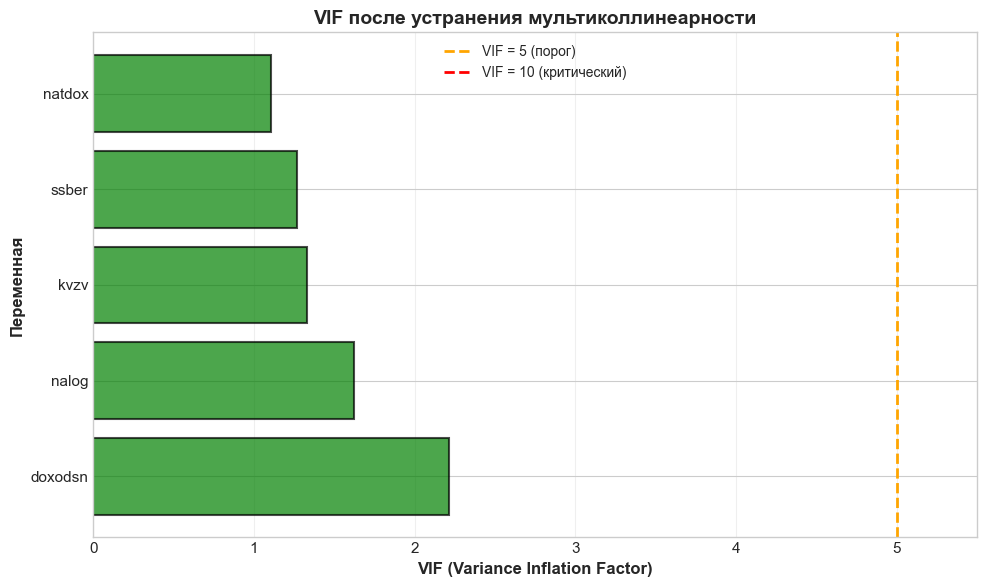


График обновленного VIF сохранен: vif_analysis_final.png
Результаты VIF сохранены: vif_results_final.csv


In [15]:
# Подготовка данных
X_final = df_analysis_final[continuous_vars_updated].copy()
X_final_const = add_constant(X_final)

# Расчет VIF для обновленного набора
vif_data_final = pd.DataFrame()
vif_data_final["Переменная"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final_const.values, i+1) 
                          for i in range(len(X_final.columns))]

vif_data_final = vif_data_final.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\n", vif_data_final.to_string(index=False))

print("\nИнтерпретация:")
print("  VIF < 5      : Мультиколлинеарность отсутствует")
print("  5 ≤ VIF < 10 : Умеренная мультиколлинеарность")
print("  VIF ≥ 10     : Сильная мультиколлинеарность")

# Проверка результата
max_vif = vif_data_final['VIF'].max()
if max_vif < 5:
    print(f"\nУСПЕХ: Максимальный VIF = {max_vif:.2f} < 5")
    print("Мультиколлинеарность устранена!")
elif max_vif < 10:
    print(f"\nВНИМАНИЕ: Максимальный VIF = {max_vif:.2f}")
    print("Присутствует умеренная мультиколлинеарность")
else:
    print(f"\n✗ ПРОБЛЕМА: Максимальный VIF = {max_vif:.2f} ≥ 10")
    print("Требуется дополнительная коррекция")

# Визуализация обновленного VIF
plt.figure(figsize=(10, 6))
colors_final = ['red' if x >= 10 else 'orange' if x >= 5 else 'green' 
                for x in vif_data_final['VIF']]
plt.barh(vif_data_final['Переменная'], vif_data_final['VIF'], 
         color=colors_final, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.xlabel('VIF (Variance Inflation Factor)', fontsize=12, fontweight='bold')
plt.ylabel('Переменная', fontsize=12, fontweight='bold')
plt.title('VIF после устранения мультиколлинеарности', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (порог)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (критический)')
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, max(vif_data_final['VIF'].max() + 0.5, 5.5))
plt.tight_layout()
plt.savefig('../results/figures/vif_analysis_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик обновленного VIF сохранен: vif_analysis_final.png")

# Сохранение результатов
vif_data_final.to_csv('../results/tables/vif_results_final.csv', index=False)
print("Результаты VIF сохранены: vif_results_final.csv")

In [ ]:
# 8.6. СОХРАНЕНИЕ ФИНАЛЬНОГО НАБОРА ДАННЫХ

In [16]:
df_analysis_final.to_csv('../results/tables/data_for_modeling.csv', index=False)

print(f"\nФинальный набор данных сохранен: data_for_modeling.csv")
print(f"  Размер: {df_analysis_final.shape[0]} наблюдений × {df_analysis_final.shape[1]} переменных")
print(f"  Переменные: {list(df_analysis_final.columns)}")


Финальный набор данных сохранен: data_for_modeling.csv
  Размер: 2605 наблюдений × 7 переменных
  Переменные: ['potras', 'doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']


In [ ]:
# 9. ВЫВОДЫ ПО EDA

1. Все выбранные переменные соответствуют требованиям задания
2. Зависимая переменная имеет значительную вариацию
3. Обнаружена и успешно устранена совершенная мультиколлинеарность
4. Финальный набор из 6 переменных не имеет проблем мультиколлинеарности (VIF < 5)
5. Переменные экономически обоснованы и готовы для регрессионного моделирования
6. На следующем этапе будет построено несколько регрессионных моделей с различными спецификациями для выбора оптимальной